# Wake Migration

This notebook demonstrates the workload behaviour when tasks are woke up

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Comment the follwing line to disable devlib debugging statements
# logging.getLogger('ssh').setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%pylab inline

import json
import os
import subprocess

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace

# Support to configure and run RTApp based workloads
from wlgen import RTA

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : "/home/lisa/android-sdk",
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
            'ip_address'     : '10.169.36.36',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },

    # Define devlib module to load
    #"modules"     : [
    #    'bl',           # enable big.LITTLE support
    #    'cpufreq'       # enable CPUFreq support
    #],

    # Account to access the remote target
    "host"        : '10.169.36.55',
    "username"    : 'root',
    "password"    : '',

    # Comment the following line to force rt-app calibration on your target

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
            "cpu_frequency",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_switch",
            'dequeue_task_fair', 
            'enqueue_task_fair', 
            'set_next_entity',

                    
            "cpu_capacity",
            
            #/sys/kernel/debug/tracing/events/sched
            "sched_blocked_reason",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_contrib_scale_f",
            "sched_cpu_hotplug",
            "sched_energy_diff",
            "sched_kthread_stop",
            "sched_kthread_stop_ret",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_migrate_task",
            "sched_move_numa",
            "sched_pi_setprio",
            "sched_process_exec",
            "sched_process_exit",
            "sched_process_fork",
            "sched_process_free",
            "sched_process_wait",
            "sched_stat_blocked",
            "sched_stat_iowait",
            "sched_stat_runtime",
            "sched_stat_sleep",
            "sched_stat_wait",
            "sched_stick_numa",
            "sched_swap_numa",
            "sched_switch",
            "sched_tune_boostgroup_update",
            "sched_tune_config",
            "sched_tune_tasks_update",
            "sched_tune_filter",
            "sched_wait_task",
            "sched_wake_idle_without_ipi",
            "sched_wakeup",
            "sched_wakeup_new",
            
            
         ],
         "buffsize" : 10240
    },
    "results_dir" : "lisa_wake_migration",
}

In [4]:
# Support to access the remote target
import devlib
from env import TestEnv

# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

09:44:11  INFO    : Using base path: /home/lisa/lisa-github
09:44:11  INFO    : Loading custom (inline) target configuration
09:44:11  INFO    : Loading custom (inline) test configuration
09:44:11  INFO    : External tools using:
09:44:11  INFO    :    ANDROID_HOME: /home/lisa/android-sdk
09:44:11  INFO    :    CATAPULT_HOME: /home/lisa/lisa-github/tools/catapult
09:44:11  INFO    : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
09:44:11  INFO    : Connecting Android target [0123456789ABCDEF]
09:44:11  INFO    : Connection settings:
09:44:11  INFO    :    {'device': '0123456789ABCDEF'}
09:44:12  INFO    : Initializing target workdir:
09:44:12  INFO    :    /data/local/tmp/devlib-target
09:44:16  INFO    : Attempting to read energy model from target
09:44:21  INFO    : Topology:
09:44:21  INFO    :    [[0, 1, 2, 3], [4, 5, 6, 7]]
09:44:21  INFO    : Loading default EM:
09:44:21  INFO    :    /home/lisa/lisa-github/libs/utils/platforms/hikey960.json
09:44:22  WARNING : Event [deque

# Workload configuration

In [5]:
# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp

# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={
        
         'wake_mig_0': Ramp(
            start_pct=10,           # intial load
            end_pct=50,            # end load
            delta_pct=40,          # load % increase...
            time_s=5,              # ... every 1[s]
            loops=2,
        ).get(),
         'wake_mig_1': Ramp(
            start_pct=10,           # intial load
            end_pct=50,            # end load
            delta_pct=40,          # load % increase...
            time_s=5,              # ... every 1[s]
            #delay_s=0.05,          # delay time to execute
            loops=2,
        ).get(),
    },
    
    # 4. use this folder for task logfiles
    run_dir=target.working_directory
    
);

09:44:22  INFO    : Setup new workload simple
09:44:22  INFO    : Workload duration defined by longest task
09:44:22  INFO    : Default policy: SCHED_OTHER
09:44:22  INFO    : ------------------------
09:44:22  INFO    : task [wake_mig_0], sched: using default policy
09:44:22  INFO    :  | loops count: 2
09:44:22  INFO    : + phase_000001: duration 5.000000 [s] (50 loops)
09:44:22  INFO    : |  period   100000 [us], duty_cycle  10 %
09:44:22  INFO    : |  run_time  10000 [us], sleep_time  90000 [us]
09:44:22  INFO    : + phase_000002: duration 5.000000 [s] (50 loops)
09:44:22  INFO    : |  period   100000 [us], duty_cycle  50 %
09:44:22  INFO    : |  run_time  50000 [us], sleep_time  50000 [us]
09:44:22  INFO    : ------------------------
09:44:22  INFO    : task [wake_mig_1], sched: using default policy
09:44:22  INFO    :  | loops count: 2
09:44:22  INFO    : + phase_000001: duration 5.000000 [s] (50 loops)
09:44:22  INFO    : |  period   100000 [us], duty_cycle  10 %
09:44:22  INFO 

# Workload execution

In [6]:
target.cpufreq.set_all_governors('sched')

logging.info("Current scheduling governor of target board is sched")
#os.system("cat /sys/devices/system/cpu/cpu0/cpufreq/scaling_governor")

09:44:22  INFO    : Current scheduling governor of target board is sched


In [7]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

09:44:22  INFO    : #### Setup FTrace
09:44:26  INFO    : #### Start energy sampling


09:44:27  INFO    : #### Start RTApp execution
09:44:27  INFO    : Workload execution START:
09:44:27  INFO    :    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1
09:44:48  INFO    : #### Read energy consumption: /home/lisa/lisa-github/results/lisa_wake_migration/energy.json
09:44:51  INFO    : #### Stop FTrace
09:44:51  INFO    : #### Save FTrace: /home/lisa/lisa-github/results/lisa_wake_migration/trace.dat
09:44:54  INFO    : #### Save platform description: /home/lisa/lisa-github/results/lisa_wake_migration/platform.json


# Collected results

In [8]:
# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

09:44:55  INFO    : Content of the output folder /home/lisa/lisa-github/results/lisa_wake_migration


total 8972
drwxrwxr-x 1 lisa lisa     316 Aug 25 09:44 .
drwxrwxr-x 1 lisa lisa    1778 Aug 25 09:44 ..
-rw-rw-r-- 1 lisa lisa      48 Aug 25 09:44 energy.json
-rw-rw-r-- 1 lisa lisa     383 Aug 25 09:44 energy_stats.json
-rw-rw-r-- 1 lisa lisa     307 Aug 25 09:44 output.log
-rw-rw-r-- 1 lisa lisa    1519 Aug 25 09:44 platform.json
-rw-r--r-- 1 lisa lisa   24960 Aug 25 09:44 rt-app-wake_mig_0-0.log
-rw-r--r-- 1 lisa lisa   24960 Aug 25 09:44 rt-app-wake_mig_1-1.log
-rw-rw-r-- 1 lisa lisa   74499 Aug 25 09:44 samples_Device0.csv
-rw-rw-r-- 1 lisa lisa   91150 Aug 25 09:44 samples_Device1.csv
-rw-r--r-- 1 lisa lisa    1465 Aug 25 09:44 simple_00.json
-rw-r--r-- 1 lisa lisa 8937472 Aug 25 09:44 trace.dat


In [9]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
#print json.dumps(rtapp_json, indent=4, sort_keys=True)

09:44:55  INFO    : Generated RTApp JSON file:


In [21]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_report.report_file)
print json.dumps(nrg_report.channels, indent=4, sort_keys=True)

09:49:34  INFO    : Energy: /home/lisa/lisa-github/results/lisa_wake_migration/energy.json


{
    "Device0": 0.0, 
    "Device1": 50030.04
}


In [22]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
#print json.dumps(plt, indent=4, sort_keys=True)

09:49:35  INFO    : Platform description: /home/lisa/lisa-github/results/lisa_wake_migration/platform.json


# Trace inspection

In [23]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.sched.SchedLoadAvgTask object at 0x7fd748ab3c50> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.SchedContribScaleFactor object at 0x7fd748ab3690> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.cpu_power.CpuOutPower object at 0x7fd748c7fed0> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.sched.SchedCpuCapacity object at 0x7fd748c7fad0> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.idle.CpuIdle object at 0x7fd7483e1710> from cache, reading i

# New Task Behavior

In [24]:
events_to_parse = my_tests_conf['ftrace']['events']

trace = Trace(plt, te.res_dir, events_to_parse)

ftrace = trace.ftrace

trappy.plotter.plot_trace(ftrace, execnames=['wake_mig_0', "wake_mig_1"])

/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.set_next_entity object at 0x7fd7482068d0> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.cpu_frequency_devlib object at 0x7fd748294250> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_move_numa object at 0x7fd748294f90> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_wait_task object at 0x7fd748acda90> from cache, reading it from trace
  warnings.warn(warnstr)
/home/lisa/lisa-github/libs/trappy/trappy/ftrace.py:205: UserWarning: TRAPpy: Couldn't read <trappy.dynamic.sched_stat_blocked object at 0x7fd748acd450> from c

# RTApp task performance plots

09:49:44  INFO    : PerfIndex, Task [wake_mig_1] avg: 0.86, std: 0.11
09:49:45  INFO    : PerfIndex, Task [wake_mig_0] avg: 0.86, std: 0.10


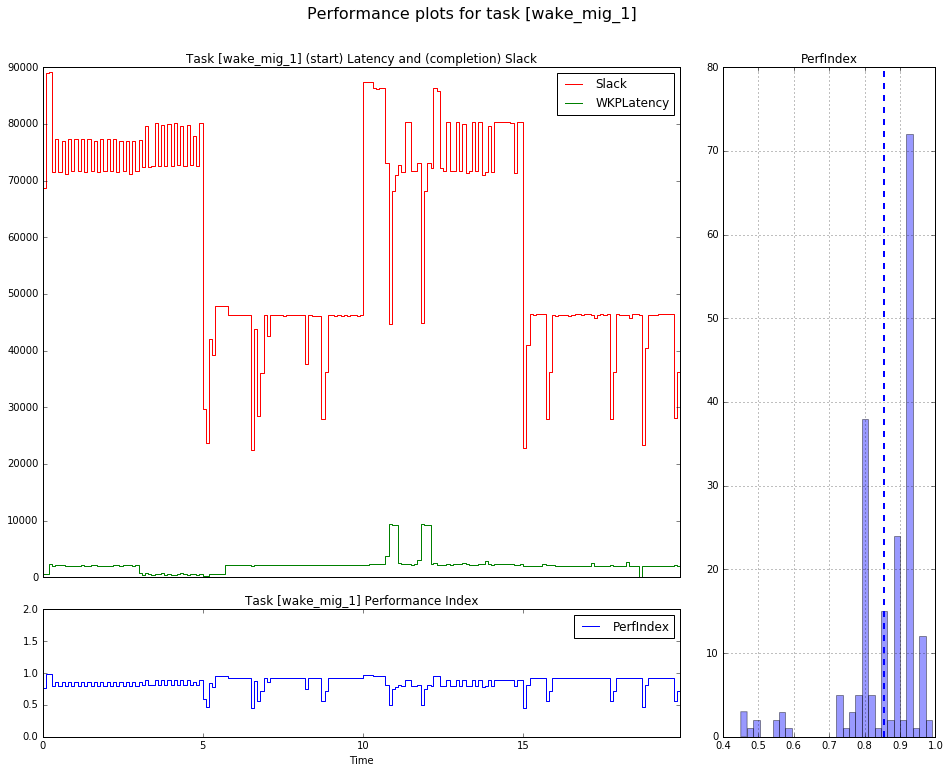

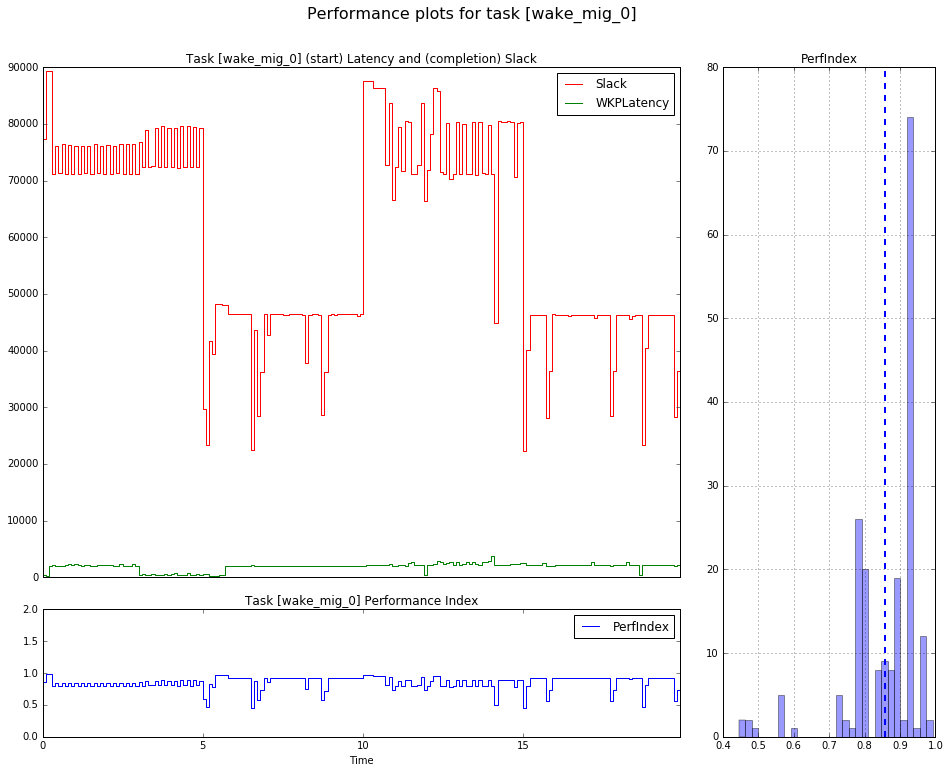

In [25]:
# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

# Trace Overview

In [26]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(ftrace)

In [27]:
# Add column with util_max = max(util_avg, util_est)
df = ftrace.sched_load_avg_cpu.data_frame

#print df[['util_avg', 'util_est']]
#print df[['util_avg']]

#df['util_max'] = df[['util_avg', 'util_est']].max(axis=1)

df['util_max'] = df[['util_avg']].max(axis=1)

In [28]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(ftrace, execnames=['wake_mig_0', 'wake_mig_1',])

# Task Utilization

In [29]:
# These two paramatere are passed to the LinePlot call as long with the
# TRAPpy Run object
trappy.ILinePlot(
    ftrace,                         # TRAPpy RUN object
    signals=[
      'sched_load_avg_task:load_avg',
      'sched_load_avg_task:util_avg'
    ],
    pivot='pid',
    filters={'comm': ['wake_mig_0', 'wake_mig_1']},
    drawstyle='steps-post',
     sync_zoom=True,
     group='PeriodicAndRamp',
    marker = '+').view()

,
,


# CPU Utilization

In [30]:
trappy.ILinePlot(
    ftrace,
    signals=[
      'sched_load_avg_cpu:load_avg',
      #'sched_load_avg_cpu:util_est',
      'sched_load_avg_cpu:util_avg',
    ],
    pivot='cpu',
    filters={'cpu': [0, 1,2,3,4,5,6,7]},
    drawstyle='steps-post',
    scatter=False,
       sync_zoom=True,
#      group='PeriodicAndRamp',
    marker = '+').view()

,
,
,
,
,
,
,
,


# CPUfreq

09:49:50  WARNING : Event [sched_overutilized] not found, plot DISABLED!
09:49:50  WARNING : Event [sched_overutilized] not found, plot DISABLED!
09:49:51  INFO    : LITTLE cluster average frequency: 0.930 GHz
09:49:51  INFO    : big    cluster average frequency: 1.708 GHz


(0.93003711109127274, 1.7076021375849606)

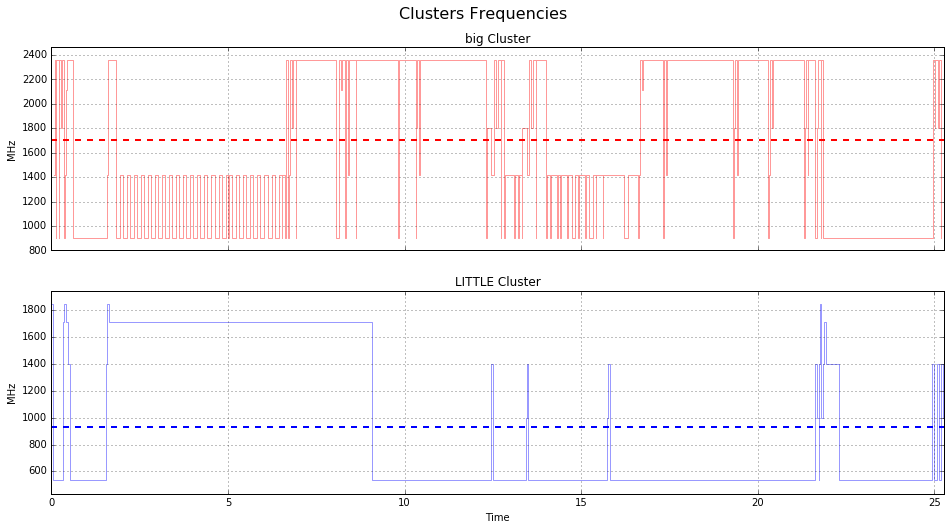

In [31]:


#from trace_analysis import plotClusterFrequencies

#ta = TraceAnalysis(te.res_dir)

trace.analysis.frequency.plotClusterFrequencies()

#plotdir(te.res_dir, plt)